In [1]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

import pandas as pd
import numpy as np
import joblib

import warnings

warnings.filterwarnings("ignore")

from afl_match_outcome_model.config import match_summary_file_path

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# tf.compat.v1.disable_v2_behavior()
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
# tf.config.experimental.enable_op_determinism()

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-01-16 15:40:15.216702: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from afl_match_outcome_model.data_preparation.preprocessing import (
    convert_home_away_to_team_opp_data,
    split_scores,
    rolling_averages,
    format_date_columns,
    format_round
)

In [49]:
matches = pd.read_csv(match_summary_file_path)
matches = convert_home_away_to_team_opp_data(matches)
matches = split_scores(matches)

matches['Team_Score_rolling1'] = matches.groupby('Team')['Team_Score'].rolling(1).mean().shift(1).reset_index(level = "Team", drop=True).sort_index()
matches['Opp_Score_rolling1'] = matches.groupby('Team')['Opp_Score'].rolling(1).mean().shift(1).reset_index(level = "Team", drop=True).sort_index()
matches['Result_rolling1'] = matches.groupby('Team')['Result'].rolling(1).mean().shift(1).reset_index(level = "Team", drop=True).sort_index()

matches['Team_Score_rolling5'] = matches.groupby('Team')['Team_Score'].rolling(5).mean().shift(1).reset_index(level = "Team", drop=True).sort_index()
matches['Opp_Score_rolling5'] = matches.groupby('Team')['Opp_Score'].rolling(5).mean().shift(1).reset_index(level = "Team", drop=True).sort_index()
matches['Result_rolling5'] = matches.groupby('Team')['Result'].rolling(5).mean().shift(1).reset_index(level = "Team", drop=True).sort_index()

matches['Team_Score_rolling20'] = matches.groupby('Team')['Team_Score'].rolling(20).mean().shift(1).reset_index(level = "Team", drop=True).sort_index()
matches['Opp_Score_rolling20'] = matches.groupby('Team')['Opp_Score'].rolling(20).mean().shift(1).reset_index(level = "Team", drop=True).sort_index()
matches['Result_rolling20'] = matches.groupby('Team')['Result'].rolling(20).mean().shift(1).reset_index(level = "Team", drop=True).sort_index()

from sklearn.preprocessing import LabelEncoder
team_encoder = LabelEncoder()
matches['Team_code'] = team_encoder.fit_transform(matches['Team'])
opp_encoder = LabelEncoder()
matches['Opp_code'] = opp_encoder.fit_transform(matches['Opponent'])

venue_encoder = LabelEncoder()
matches['Venue_code'] = opp_encoder.fit_transform(matches['Venue'])
city_encoder = LabelEncoder()
matches['City_code'] = opp_encoder.fit_transform(matches['City'])

rolling_cols = [x for x in list(matches) if "rolling" in x]
matches = matches.dropna(subset = rolling_cols)

matches.head()

,Team,Opponent,Margin,Total Game Score,Venue,City,Date,Temperature,Year,Round_ID,Match_ID,Home,Result,Team_Score,Opp_Score,Team_Goals,Opp_Goals,Team_Behinds,Opp_Behinds,Team_Score_rolling1,Opp_Score_rolling1,Result_rolling1,Team_Score_rolling5,Opp_Score_rolling5,Result_rolling5,Team_Score_rolling20,Opp_Score_rolling20,Result_rolling20,Team_code,Opp_code,Venue_code,City_code
0,Carlton,Brisbane Lions,40,264,Princes Park,Melbourne,2000-03-13 14:10:00,NaN,2000,200001,200001_Carlton_BrisbaneLions,1,1,152,112,22,16,20,16,86.0,90.0,0.0,96.8,77.6,0.8,93.7,73.85,0.75,2,1,16,11
1,Brisbane Lions,Carlton,-40,264,Princes Park,Melbourne,2000-03-13 14:10:00,NaN,2000,200001,200001_Carlton_BrisbaneLions,0,0,112,152,16,22,16,20,123.0,78.0,1.0,98.0,75.4,0.6,95.5,78.85,0.50,1,2,16,11
2,Essendon,Port Adelaide,94,218,Docklands,Melbourne,2000-03-09 20:15:00,NaN,2000,200001,200001_Essendon_PortAdelaide,1,1,156,62,24,8,12,14,90.0,86.0,1.0,81.8,70.2,0.8,89.2,70.50,0.80,4,12,5,11
3,Port Adelaide,Essendon,-94,218,Docklands,Melbourne,2000-03-09 20:15:00,NaN,2000,200001,200001_Essendon_PortAdelaide,0,0,62,156,8,24,14,12,132.0,97.0,1.0,83.8,91.8,0.2,71.0,100.60,0.05,12,4,5,11
4,Fremantle,Geelong,-22,236,Subiaco,Perth,2000-03-11 20:40:00,NaN,2000,200001,200001_Fremantle_Geelong,1,0,107,129,16,19,11,15,31.0,101.0,0.0,65.0,102.6,0.4,76.6,90.65,0.45,5,6,20,12


In [50]:
features = ['Team_Score_rolling1', 'Opp_Score_rolling1', 'Result_rolling1', 'Team_Score_rolling5', 'Opp_Score_rolling5', 'Result_rolling5', 'Team_Score_rolling20','Opp_Score_rolling20', 'Result_rolling20', 'Team_code', 'Opp_code', 'Venue_code', 'City_code']
df = matches[['Team', 'Date', 'Result'] + features].sort_values(by = ['Date'])
df.head()

,Team,Date,Result,Team_Score_rolling1,Opp_Score_rolling1,Result_rolling1,Team_Score_rolling5,Opp_Score_rolling5,Result_rolling5,Team_Score_rolling20,Opp_Score_rolling20,Result_rolling20,Team_code,Opp_code,Venue_code,City_code
11,Melbourne,2000-03-08 19:40:00,0,56.0,93.0,0.0,76.2,87.8,0.4,75.45,89.1,0.35,10,13,11,11
10,Richmond,2000-03-08 19:40:00,1,70.0,93.0,0.0,89.8,84.4,0.6,94.10,83.9,0.70,13,10,11,11
2,Essendon,2000-03-09 20:15:00,1,90.0,86.0,1.0,81.8,70.2,0.8,89.20,70.5,0.80,4,12,5,11
3,Port Adelaide,2000-03-09 20:15:00,0,132.0,97.0,1.0,83.8,91.8,0.2,71.00,100.6,0.05,12,4,5,11
8,North Melbourne,2000-03-10 19:40:00,0,71.0,73.0,0.0,68.8,61.8,0.4,83.45,69.2,0.65,11,16,11,11


Train Val Test

In [79]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = len(features)

Normalize

In [204]:
train_mean = train_df[features].mean()
train_std = train_df[features].std()

df[features] = (df[features] - train_mean) / train_std
train_df[features] = (train_df[features] - train_mean) / train_std
val_df[features] = (val_df[features] - train_mean) / train_std
test_df[features] = (test_df[features] - train_mean) / train_std

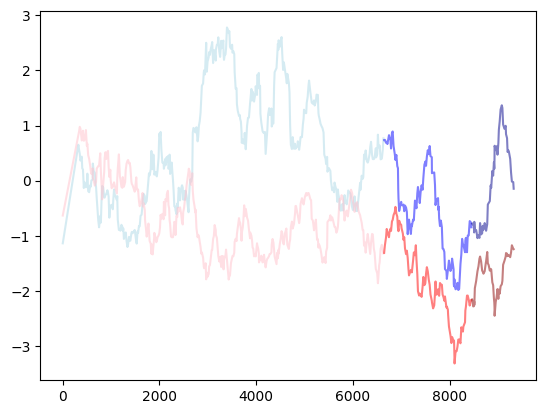

In [205]:
# for team in df['Team'].unique():
#     plt.plot(df[df['Team'] == team]['Team_Score_rolling20'], label = team, alpha = 0.5)

team = "Geelong"
plt.plot(train_df[train_df['Team'] == team]['Team_Score_rolling20'], label = team, alpha = 0.5, color = "lightblue")
plt.plot(val_df[val_df['Team'] == team]['Team_Score_rolling20'], label = team, alpha = 0.5, color = "blue")
plt.plot(test_df[test_df['Team'] == team]['Team_Score_rolling20'], label = team, alpha = 0.5, color = "darkblue")

plt.plot(train_df[train_df['Team'] == team]['Opp_Score_rolling20'], label = team, alpha = 0.5, color ="pink")
plt.plot(val_df[val_df['Team'] == team]['Opp_Score_rolling20'], label = team, alpha = 0.5, color = "red")
plt.plot(test_df[test_df['Team'] == team]['Opp_Score_rolling20'], label = team, alpha = 0.5, color = "darkred")

Create Sequences

In [206]:
import pandas as pd
import numpy as np
import tensorflow as tf

def create_lstm_dataset(df, target_column, time_steps=5):
    """
    Converts a pandas DataFrame into LSTM input sequences for each individual team.

    Parameters:
    - df: pandas DataFrame, input features with 'Team' and 'Date' columns
    - target_column: str, the target variable column name
    - time_steps: int, number of time steps (sequences)

    Returns:
    - X_lstm: numpy array, LSTM input features for all teams
    - y_lstm: numpy array, corresponding target variables for all teams
    - team_mapping: dictionary, mapping of team names to their corresponding indices in X_lstm and y_lstm
    """

    # Ensure the DataFrame is sorted by 'Date' for proper sequence creation
    df = df.sort_values(by=['Team', 'Date'])

    # Extract unique team names
    unique_teams = df['Team'].unique()

    # Create a mapping of team names to their corresponding indices in X_lstm and y_lstm
    team_mapping = {team: i for i, team in enumerate(unique_teams)}

    # Create arrays for X_lstm and y_lstm
    X_lstm = []
    y_lstm = []

    for team in unique_teams:
        team_data = df[df['Team'] == team]

        # Convert DataFrame to numpy arrays
        X_array = team_data.drop(['Team', 'Date', target_column], axis=1).to_numpy().astype(np.float32)
        y_array = team_data[target_column].to_numpy().astype(np.float32)

        # Calculate the number of samples
        num_samples, num_features = X_array.shape

        # Calculate the expected size after reshaping
        expected_size = num_samples - time_steps + 1

        # Create arrays for LSTM input features and target variable
        X_team_lstm = np.zeros((expected_size, time_steps, num_features), dtype=np.float32)
        y_team_lstm = np.zeros(expected_size, dtype=np.float32)

        # Create LSTM input sequences for the current team
        for i in range(expected_size):
            X_team_lstm[i] = X_array[i:i + time_steps, :]
            y_team_lstm[i] = y_array[i + time_steps - 1]

        # Append the sequences to the arrays
        X_lstm.append(X_team_lstm)
        y_lstm.append(y_team_lstm)

    # Stack the arrays to create the final numpy arrays
    X_lstm = np.vstack(X_lstm)
    y_lstm = np.concatenate(y_lstm)

    return X_lstm, y_lstm, team_mapping

In [208]:
df = df.sort_values(by=['Team', 'Date'])

train_df = train_df.sort_values(by=['Team', 'Date'])
val_df = val_df.sort_values(by=['Team', 'Date'])
test_df = test_df.sort_values(by=['Team', 'Date'])

Convert to sequences

In [209]:
TIME_STEPS = 5
X_lstm, y_lstm, team_mapping = create_lstm_dataset(df, target_column='Result', time_steps=TIME_STEPS)
X_train_lstm, y_train_lstm, team_mapping = create_lstm_dataset(train_df, target_column='Result', time_steps=TIME_STEPS)
X_val_lstm, y_val_lstm, team_mapping = create_lstm_dataset(val_df, target_column='Result', time_steps=TIME_STEPS)
X_test_lstm, y_test_lstm, team_mapping = create_lstm_dataset(test_df, target_column='Result', time_steps=TIME_STEPS)

Drop first (TIME_STEP - 1) rows from df so predictions line up with input

In [210]:
lagged_rows = TIME_STEPS-1
df_lstm = df.groupby('Team').apply(lambda group: group.iloc[lagged_rows:]).reset_index(level = 'Team', drop = True)
train_df_lstm = train_df.groupby('Team').apply(lambda group: group.iloc[lagged_rows:]).reset_index(level = 'Team', drop = True)
val_df_lstm = val_df.groupby('Team').apply(lambda group: group.iloc[lagged_rows:]).reset_index(level = 'Team', drop = True)
test_df_lstm = test_df.groupby('Team').apply(lambda group: group.iloc[lagged_rows:]).reset_index(level = 'Team', drop = True)

In [211]:
X_train_lstm[0], y_train_lstm[0]

(array([[-0.9098522 ,  0.20601013, -1.0042132 ,  0.49086788,  0.72015435,
         -0.38006416,  0.8884551 ,  0.8864245 , -0.27002645, -1.5920444 ,
          0.6343657 , -0.59077674, -2.1819804 ],
        [-0.02239276,  1.6685055 , -1.0042132 , -0.22444591,  1.0828604 ,
         -1.1247158 ,  0.8884551 ,  1.0280845 , -0.27002645, -1.5920444 ,
          1.1918162 ,  1.2929761 ,  1.1562476 ],
        [-0.6613636 ,  1.2047875 , -1.0042132 , -0.58860564,  1.2883937 ,
         -1.1247158 ,  0.7719722 ,  1.0871094 , -0.27002645, -1.5920444 ,
          0.262732  , -0.59077674, -2.1819804 ],
        [-0.44837332, -0.32904917, -1.0042132 , -0.93975973,  1.2037623 ,
         -1.8693675 ,  0.803333  ,  0.67786944, -0.27002645, -1.5920444 ,
          0.6343657 , -0.59077674, -2.1819804 ],
        [-0.16438627,  2.1678941 , -1.0042132 , -0.80970263,  1.6631899 ,
         -1.8693675 ,  0.78541255,  0.79985446, -0.27002645, -1.5920444 ,
         -1.2238028 ,  0.95047563,  0.44091305]], dtype=float32)

LSTM

In [212]:
def compile_and_fit(model, 
                    X_train, y_train,
                    X_val, y_val, 
                    epochs = 50,
                    batch = 32,
                    verbose = 0,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy']):
    
    model.compile(loss = loss,
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = metrics)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch, verbose=verbose  # Adjust epochs and batch_size as needed
    )
    
    return history

In [235]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [236]:
lstm_model.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics = ['accuracy'])

2024-01-16 16:49:21.391814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-16 16:49:21.393142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-16 16:49:21.393928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

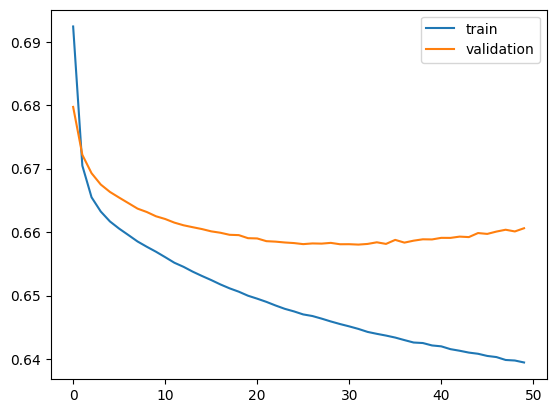

In [237]:
history = compile_and_fit(lstm_model, X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, epochs = 50)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()

In [238]:
lstm_model.evaluate(X_train_lstm, y_train_lstm)

195/195 [==============================] - 0s 585us/step - loss: 0.6379 - accuracy: 0.6341


[0.6379457116127014, 0.6340876221656799]

In [239]:
lstm_model.evaluate(X_val_lstm, y_val_lstm)

55/55 [==============================] - 0s 702us/step - loss: 0.6606 - accuracy: 0.6154


[0.660609781742096, 0.6153846383094788]

In [240]:
lstm_model.evaluate(X_test_lstm, y_test_lstm)

26/26 [==============================] - 0s 653us/step - loss: 0.6650 - accuracy: 0.5983


[0.6650401949882507, 0.5983112454414368]

In [241]:
train_probas = lstm_model.predict(X_train_lstm)
val_probas = lstm_model.predict(X_val_lstm)
test_probas = lstm_model.predict(X_test_lstm)

 58/195 [=======>......................] - ETA: 0s 

2024-01-16 16:50:05.082410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-16 16:50:05.084008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-16 16:50:05.085231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 565us/step


In [242]:
train_probas.mean(), y_train_lstm.mean()

(0.5021008, 0.50312954)

In [243]:
val_probas.mean(), y_val_lstm.mean()

(0.50887126, 0.49971083)

In [244]:
test_probas.mean(), y_test_lstm.mean()

(0.5036985, 0.49939686)

In [245]:
from sklearn.metrics import log_loss, brier_score_loss

In [246]:
log_loss(y_train_lstm, train_probas), brier_score_loss(y_train_lstm, train_probas)

(0.6379457252912927, 0.22368843595165536)

In [247]:
log_loss(y_val_lstm, val_probas), brier_score_loss(y_val_lstm, val_probas)

(0.6606097965019789, 0.23403678508588427)

In [248]:
log_loss(y_test_lstm, test_probas), brier_score_loss(y_test_lstm, test_probas)

(0.6650402281529756, 0.23618408125420115)

In [249]:
df_lstm['lstm_probas'] = lstm_model.predict(X_lstm)
train_df_lstm['lstm_probas'] = lstm_model.predict(X_train_lstm)
val_df_lstm['lstm_probas'] = lstm_model.predict(X_val_lstm)
test_df_lstm['lstm_probas'] = lstm_model.predict(X_test_lstm)

26/26 [==============================] - 0s 507us/step


In [307]:
from sklearn.metrics import median_absolute_error, explained_variance_score

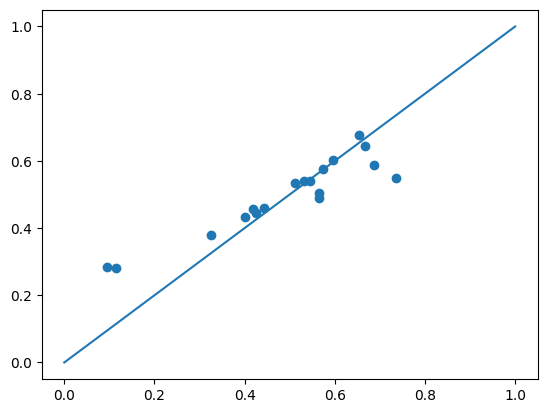

In [315]:
test_teams = test_df_lstm.groupby('Team').agg(
    result = ("Result", "mean"),
    probas = ("lstm_probas", "mean")
)
test_teams['absolute_error'] = abs(test_teams['result'] - test_teams['probas'])
plt.scatter(test_teams['result'], test_teams['probas'])
plt.plot([0, 1], [0, 1])

In [250]:
import matplotlib.dates as mdates

In [270]:
def plot_team_ave(data, team):
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    team_lstm = data[data['Team'] == team]
    team_lstm['Date'] = pd.to_datetime(team_lstm['Date'])
    
    ax.scatter(x=team_lstm['Date'], y = team_lstm['Result'])
    ax.scatter(x=team_lstm['Date'], y = team_lstm['lstm_probas'])
    
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)
    plt.show()

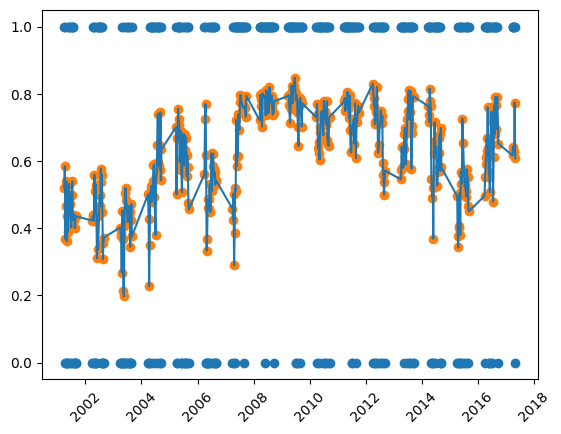

In [269]:
plot_team_ave(train_df_lstm, "Geelong")

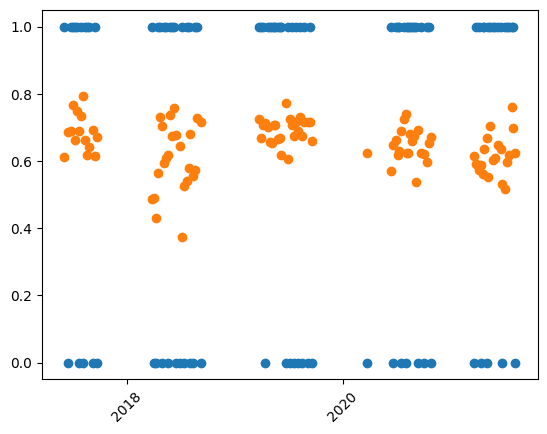

In [271]:
plot_team_ave(val_df_lstm, "Geelong")

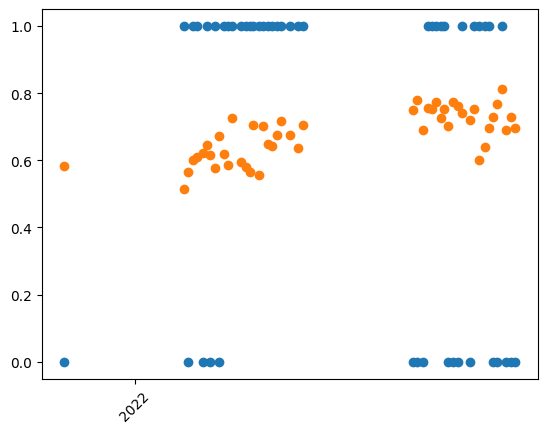

In [254]:
plot_team_ave(test_df_lstm, "Geelong")

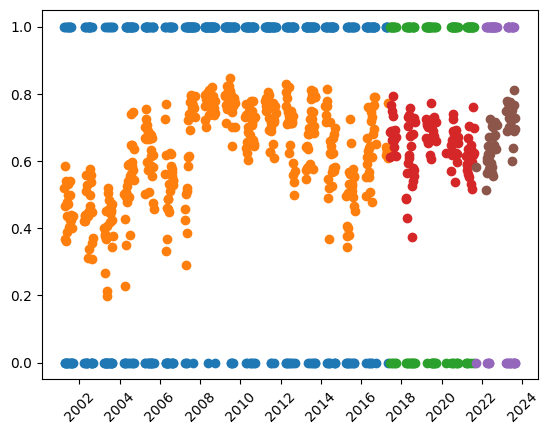

In [255]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

team_lstm = train_df_lstm[train_df_lstm['Team'] == team]
team_lstm['Date'] = pd.to_datetime(team_lstm['Date'])

ax.scatter(x=team_lstm['Date'], y = team_lstm['Result'])
ax.scatter(x=team_lstm['Date'], y = team_lstm['lstm_probas'])

team_lstm = val_df_lstm[val_df_lstm['Team'] == team]
team_lstm['Date'] = pd.to_datetime(team_lstm['Date'])

ax.scatter(x=team_lstm['Date'], y = team_lstm['Result'])
ax.scatter(x=team_lstm['Date'], y = team_lstm['lstm_probas'])

team_lstm = test_df_lstm[test_df_lstm['Team'] == team]
team_lstm['Date'] = pd.to_datetime(team_lstm['Date'])

ax.scatter(x=team_lstm['Date'], y = team_lstm['Result'])
ax.scatter(x=team_lstm['Date'], y = team_lstm['lstm_probas'])

ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)
plt.show()

In [ ]:
def plot(self, model=None, plot_col='Result', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [matches]')

In [276]:
def plot_sequence_prediction(data, index):
    
    input_indices = range(index-4, index)
    
    label = data['Result'].iloc[index]
    prediction = data['lstm_probas'].iloc[index]
    
    sequence = data['Result'].iloc[index-4:index]
    
    plt.ylabel('Result')
    plt.plot(input_indices, sequence,
             label='Inputs', marker='.', zorder=-10)
    
    plt.scatter(index, label,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    plt.scatter(index, prediction,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

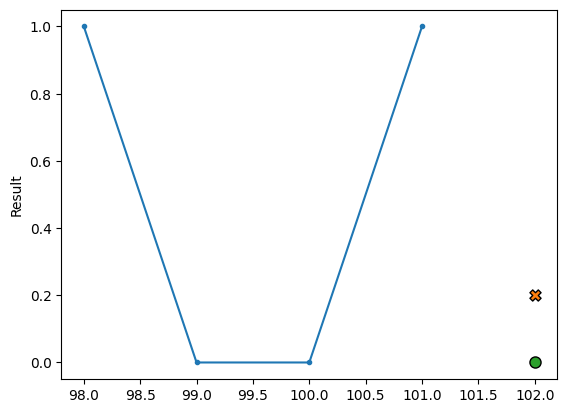

In [284]:
plot_sequence_prediction(val_df_lstm, index=102)